In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import shap

Using TensorFlow backend.


# FER 2013 Data Set

In [2]:
class_names = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

In [3]:
num_classes = len(class_names)

## Load Data Set

In [4]:
with open("fer2013.csv") as f:
    content = f.readlines()

In [5]:
lines = np.array(content)
num_of_instances = lines.size

In [6]:
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35918
instance length:  2304


In [7]:
x_train, y_train, x_test, y_test = [], [], [], []

for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

In [8]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


## Construct Model

In [9]:
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [10]:
# https://github.com/serengil/tensorflow-101/blob/master/model/facial_expression_model_weights.h5
model.load_weights('facial_expression_model_weights.h5')

## Gradient Explainer

In [11]:
x_train = np.expand_dims(x_train, axis = 1)
x_test = np.expand_dims(x_test, axis = 1)

In [12]:
x_train.shape

(28709, 1, 48, 48, 1)

In [13]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], x.copy()))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [14]:
def explain(x_train, sample, layer):
    to_explain = x_train[[sample]]
    #print(to_explain.shape)
    
    e = shap.GradientExplainer(
        (model.layers[layer].input, model.layers[-1].output),
        map2layer(x_train, layer), 
        local_smoothing=0 # std dev of smoothing noise
    )
    
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)
    
    index_names = np.vectorize(lambda x: class_names[x])(indexes)
    
    shap.image_plot(shap_values, to_explain[0], index_names)

layer  0 :  <keras.layers.convolutional.Conv2D object at 0x7f08d04f84a8>


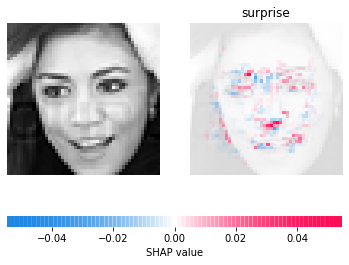

------------------
layer  1 :  <keras.layers.pooling.MaxPooling2D object at 0x7f08d04f8588>


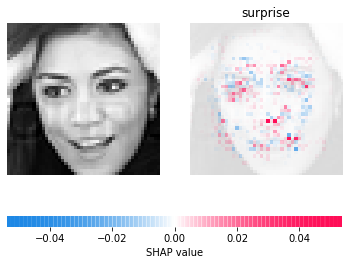

------------------
layer  2 :  <keras.layers.convolutional.Conv2D object at 0x7f08d04f8898>


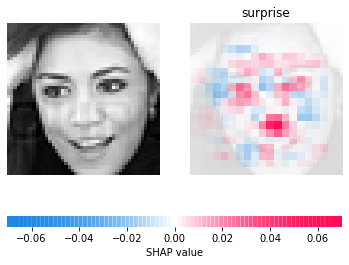

------------------
layer  3 :  <keras.layers.convolutional.Conv2D object at 0x7f08d04d8ef0>


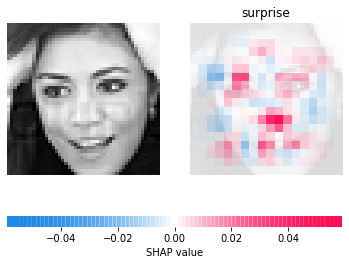

------------------
layer  4 :  <keras.layers.pooling.AveragePooling2D object at 0x7f08d04f89b0>


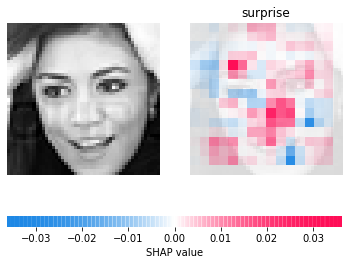

------------------


In [15]:
sample = 39
for layer in range(0,5):
    print("layer ",layer,": ",model.layers[layer])
    explain(x_train, sample, layer)
    print("------------------")

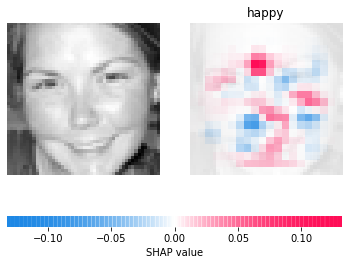

In [16]:
sample = 8
explain(x_train, sample, 2)

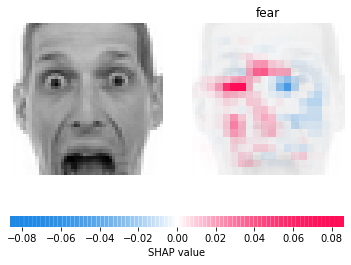

In [17]:
sample = 9
explain(x_train, sample, 2)

## Explain prediction in the test set

In [18]:
x_train.shape

(28709, 1, 48, 48, 1)

In [19]:
x_test.shape

(3589, 1, 48, 48, 1)

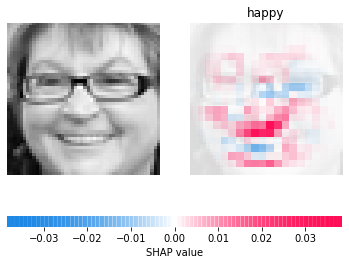

In [20]:
sample = 100
explain(x_test, sample, 2)

In [21]:
"""#check prediction for that picture
testing_img = np.array(x_train[sample], 'float32')
testing_img = testing_img.reshape([48, 48])

plt.gray()
plt.imshow(testing_img)
plt.show()

actual = y_train[sample]
prediction = model.predict(x_train[sample])
print("Prediction: ",class_names[np.argmax(prediction)])
print("Actual: ",class_names[np.argmax(actual)])
"""

'#check prediction for that picture\ntesting_img = np.array(x_train[sample], \'float32\')\ntesting_img = testing_img.reshape([48, 48])\n\nplt.gray()\nplt.imshow(testing_img)\nplt.show()\n\nactual = y_train[sample]\nprediction = model.predict(x_train[sample])\nprint("Prediction: ",class_names[np.argmax(prediction)])\nprint("Actual: ",class_names[np.argmax(actual)])\n'

## Deep Explainer

In [22]:
x_train.shape

(28709, 1, 48, 48, 1)

In [23]:
np.rollaxis(x_train, 1)[0].shape

(28709, 48, 48, 1)

In [24]:
#remove 2nd dummy dimension
x_train = np.rollaxis(x_train, 1)[0]

In [25]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

In [26]:
e = shap.DeepExplainer(model, background)

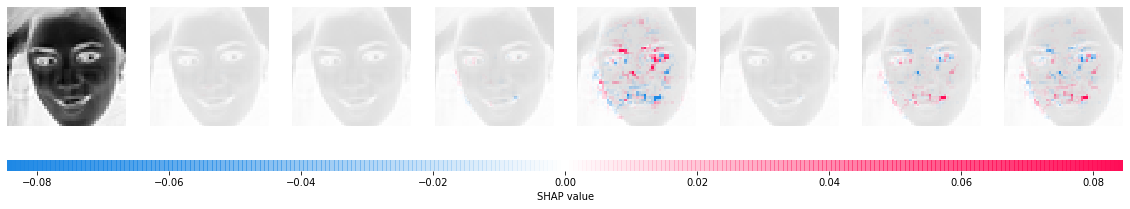

In [27]:
begin = 39; end = 40
shap_values = e.shap_values(x_train[begin:end])
shap.image_plot(shap_values, -x_train[begin:end])

# Tabular Data

In [28]:
class_names = ['setosa', 'versicolor', 'virginica']
feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width']

In [29]:
attributes = pd.read_csv("iris-attr.data", delimiter=",", names = feature_names)
label = np.genfromtxt("iris-labels.data", dtype="int64")

In [30]:
num_classes = np.unique(label).shape[0]

In [31]:
label = keras.utils.to_categorical(label, num_classes)

In [32]:
model = Sequential()
model.add(Dense(4 #num of hidden units
    , input_shape=(attributes.shape[1],))) #num of features in input layer
model.add(Activation('sigmoid')) #activation function from input layer to 1st hidden layer
model.add(Dense(num_classes)) #num of classes in output layer
model.add(Activation('sigmoid')) #activation function from 1st hidden layer to output layer

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(attributes, label, epochs=1000, verbose=0)

In [34]:
predictions = model.predict(attributes)

In [36]:
classified = 0

index = 0
for i in predictions:
    pred = np.argmax(i)
    actual = np.argmax(label[index])
    
    #print(pred, " vs ", actual)
    
    if pred == actual:
        classified = classified + 1
    #print(" prediction: ",pred," - actual: ",actual)
    index = index + 1

print("Accuracy: ",100*classified/len(predictions),"%")

Accuracy:  98.0 %


## Explainer

In [37]:
explainer = shap.KernelExplainer(model.predict, attributes, link="logit")

Using 150 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [38]:
shap_values = explainer.shap_values(attributes, nsamples=100)

/workspaces/96273/.local/lib/python3.6/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


In [39]:
shap.initjs()

In [40]:
sample = 114

In [44]:
print("Prediction for ",sample,"th instance is ",predictions[sample]," (",class_names[np.argmax(predictions[sample])],")")

Prediction for  114 th instance is  [0.00029955 0.01328751 0.20471342]  ( virginica )


In [43]:
print("actual: ",class_names[np.argmax(label[114])])

actual:  virginica


In [45]:
print("Features:")
print(attributes.iloc[sample])
print("-----------")
print("Actual:", class_names[np.argmax(label[114])])
print("Prediction: for ",class_names[np.argmax(predictions[sample])])

Features:
sepal length    5.8
sepal width     2.8
petal length    5.1
petal width     2.4
Name: 114, dtype: float64
-----------
Actual: virginica
Prediction: for  virginica


In [46]:
prediction_class = np.argmax(predictions[sample])

## Single Explanations

In [47]:
print("Prediction: ",class_names[prediction_class])
shap.force_plot(explainer.expected_value[0], shap_values[prediction_class][0,:], attributes.iloc[sample])

Prediction:  virginica


## Many Explanations

In [48]:
print("virginica")
shap.force_plot(explainer.expected_value[0], shap_values[prediction_class], attributes, link="logit")

virginica


## Feature Importance

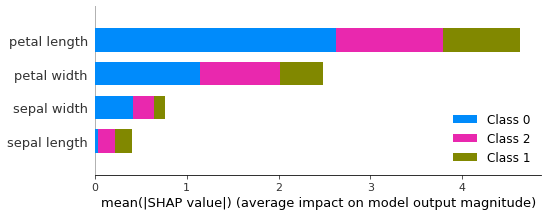

In [49]:
shap.summary_plot(shap_values, attributes, plot_type="bar")

Feature importances for  setosa


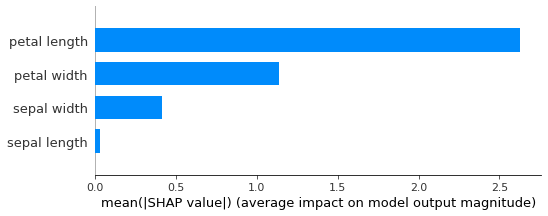

----------------------
Feature importances for  versicolor


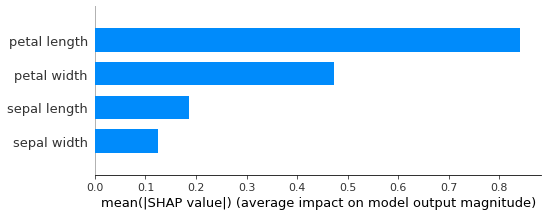

----------------------
Feature importances for  virginica


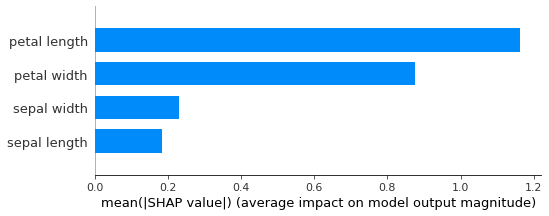

----------------------


In [50]:
for i in range(0, len(class_names)):
    current_class = class_names[i]
    print("Feature importances for ",current_class)
    shap.summary_plot(shap_values[i], attributes, plot_type="bar")
    print("----------------------")
    